<a href="https://colab.research.google.com/github/wwangvodafone/GAN/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
!wget --no-check-certificate \
    http://133.18.23.48:8080/img_align_celeba.zip \
    -O /tmp/img_align_celeba.zip

--2021-03-14 10:59:26--  http://133.18.23.48:8080/img_align_celeba.zip
Connecting to 133.18.23.48:8080... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10356313579 (9.6G) [application/zip]
Saving to: ‘/tmp/img_align_celeba.zip’

/tmp/img_align_cele 100%[===================>]   9.64G  4.14MB/s    in 52m 37s 

2021-03-14 11:52:03 (3.13 MB/s) - ‘/tmp/img_align_celeba.zip’ saved [10356313579/10356313579]



In [2]:
!wget --no-check-certificate \
    http://133.18.23.48:8080/list_attr_celeba.csv \
    -O /tmp/list_attr_celeba.csv

--2021-03-14 11:56:36--  http://133.18.23.48:8080/list_attr_celeba.csv
Connecting to 133.18.23.48:8080... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24913333 (24M) [application/octet-stream]
Saving to: ‘/tmp/list_attr_celeba.csv’

/tmp/list_attr_cele 100%[===================>]  23.76M  3.07MB/s    in 9.2s    

2021-03-14 11:56:45 (2.59 MB/s) - ‘/tmp/list_attr_celeba.csv’ saved [24913333/24913333]



In [3]:
import os
import zipfile

local_zip = '/tmp/img_align_celeba.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
import sys
sys.path.append('/content/drive/My Drive/')

In [ ]:
import os
import zipfile
DATA_FOLDER = '/content/drive/My Drive/data/celeb/image_align_celeb'
ZIP_FOLDER = '/content/drive/My Drive/data/celeb/'
print(os.path.exists(ZIP_FOLDER))
local_zip = os.path.join(ZIP_FOLDER, 'img_align_celeb.zip')
print(os.path.exists(local_zip))
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(DATA_FOLDER)
zip_ref.close()

True
True


In [7]:
import os
from glob import glob
import numpy as np

from models.VAE import VariationalAutoencoder
from keras.preprocessing.image import ImageDataGenerator

In [8]:
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = '/content/drive/My Drive/run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

In [9]:
INPUT_DIM = (128,128,3)
BATCH_SIZE = 32
DATA_FOLDER = '/tmp/img_align_celeba/'
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))

NUM_IMAGES = len(filenames)
print(NUM_IMAGES)

99999


In [20]:
data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(DATA_FOLDER
                      , target_size = INPUT_DIM[:2]
                      , batch_size = BATCH_SIZE
                      , shuffle = True
                      , class_mode = 'input'
                      , subset = "training"
                        )

Found 99999 images belonging to 1 classes.


In [21]:
vae = VariationalAutoencoder(
                input_dim = INPUT_DIM
                , encoder_conv_filters=[32,64,64, 64]
                , encoder_conv_kernel_size=[3,3,3,3]
                , encoder_conv_strides=[2,2,2,2]
                , decoder_conv_t_filters=[64,64,32,3]
                , decoder_conv_t_kernel_size=[3,3,3,3]
                , decoder_conv_t_strides=[2,2,2,2]
                , z_dim=200
                , use_batch_norm=True
                , use_dropout=True)

mode =  'build' #'load' #
if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [12]:
vae.encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         encoder_conv_0[0][0]             
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [13]:
vae.decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              823296    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0   

In [14]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 10000
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [18]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [23]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [ ]:
vae.train_with_generator(     
    data_flow
    , epochs = EPOCHS
    , steps_per_epoch = NUM_IMAGES / BATCH_SIZE
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3125/3124 [==============================] - ETA: 0s - batch: 1562.0000 - size: 31.9997 - loss: 388.3127 - vae_r_loss: 313.0799 - vae_kl_loss: 75.2326
Epoch 00001: saving model to run/vae/0001_faces/weights/weights-001-388.32.h5

Epoch 00001: saving model to run/vae/0001_faces/weights/weights.h5
3124/3124 [==============================] - 787s 241ms/step - batch: 1562.0000 - size: 31.9997 - loss: 388.3127 - vae_r_loss: 313.0799 - vae_kl_loss: 75.2326
Epoch 2/200
3125/3124 [==============================] - ETA: 0s - batch: 1562.0000 - size: 31.9997 - loss: 317.7262 - vae_r_loss: 247.0923 - vae_kl_loss: 70.6337
Epoch 00002: saving model to run/vae/0001_faces/weights/weights-002-317.73.h5

Epoch 00002: saving model to run/vae/0001_faces/weights/weights.h5
3124/3124 [==============================] - 730s 234ms/step - batch: 1562.0000 - size: 31.9997 - loss: 317.7262 - vae_r_loss: 247.0923 - vae_kl_loss: 70.6337
Epoch 3/200
3125/3124 [==============================] - ETA: 0s - batch: 15

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils.loaders import load_model, ImageLabelLoader

DATA_FOLDER = '/content/drive/My Drive/data/celeb/'
IMAGE_FOLDER = '/content/drive/My Drive/data/celeb/image_align_celeb/'

In [ ]:


INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

In [ ]:
att.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,Unnamed: 41
0,110000.jpg,-1,1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,NaN
1,110001.jpg,1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,1,-1,1,NaN
2,110002.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,1,1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,1,NaN
3,110003.jpg,1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,1,NaN
4,110004.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,NaN


Found 10000 validated image filenames.
(array([[[[0.96470594, 0.9725491 , 0.95294124],
         [0.9568628 , 0.8862746 , 0.8078432 ],
         [0.9176471 , 0.8941177 , 0.8470589 ],
         ...,
         [0.9803922 , 0.91372555, 0.8745099 ],
         [0.98823535, 0.9215687 , 0.882353  ],
         [1.        , 0.9686275 , 0.9294118 ]],

        [[0.98823535, 0.9568628 , 0.9450981 ],
         [0.6313726 , 0.5019608 , 0.427451  ],
         [0.48627454, 0.3921569 , 0.34509805],
         ...,
         [0.7019608 , 0.5764706 , 0.48627454],
         [0.70980394, 0.58431375, 0.49411768],
         [0.9921569 , 0.9490197 , 0.86274517]],

        [[1.        , 0.9725491 , 0.9568628 ],
         [0.69803923, 0.53333336, 0.43921572],
         [0.59607846, 0.427451  , 0.3647059 ],
         ...,
         [0.74509805, 0.5647059 , 0.43137258],
         [0.75294125, 0.57254905, 0.43921572],
         [0.9333334 , 0.89019614, 0.7803922 ]],

        ...,

        [[0.95294124, 0.95294124, 0.9215687 ],
     

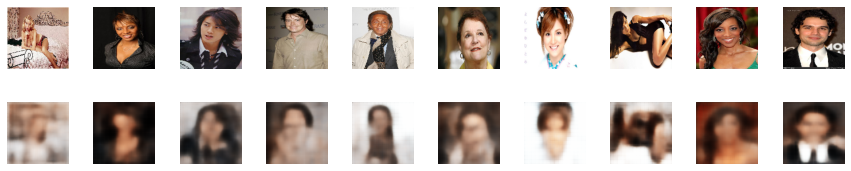

In [ ]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)
example_batch = next(data_flow_generic)
example_images = example_batch[0]
z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1301: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


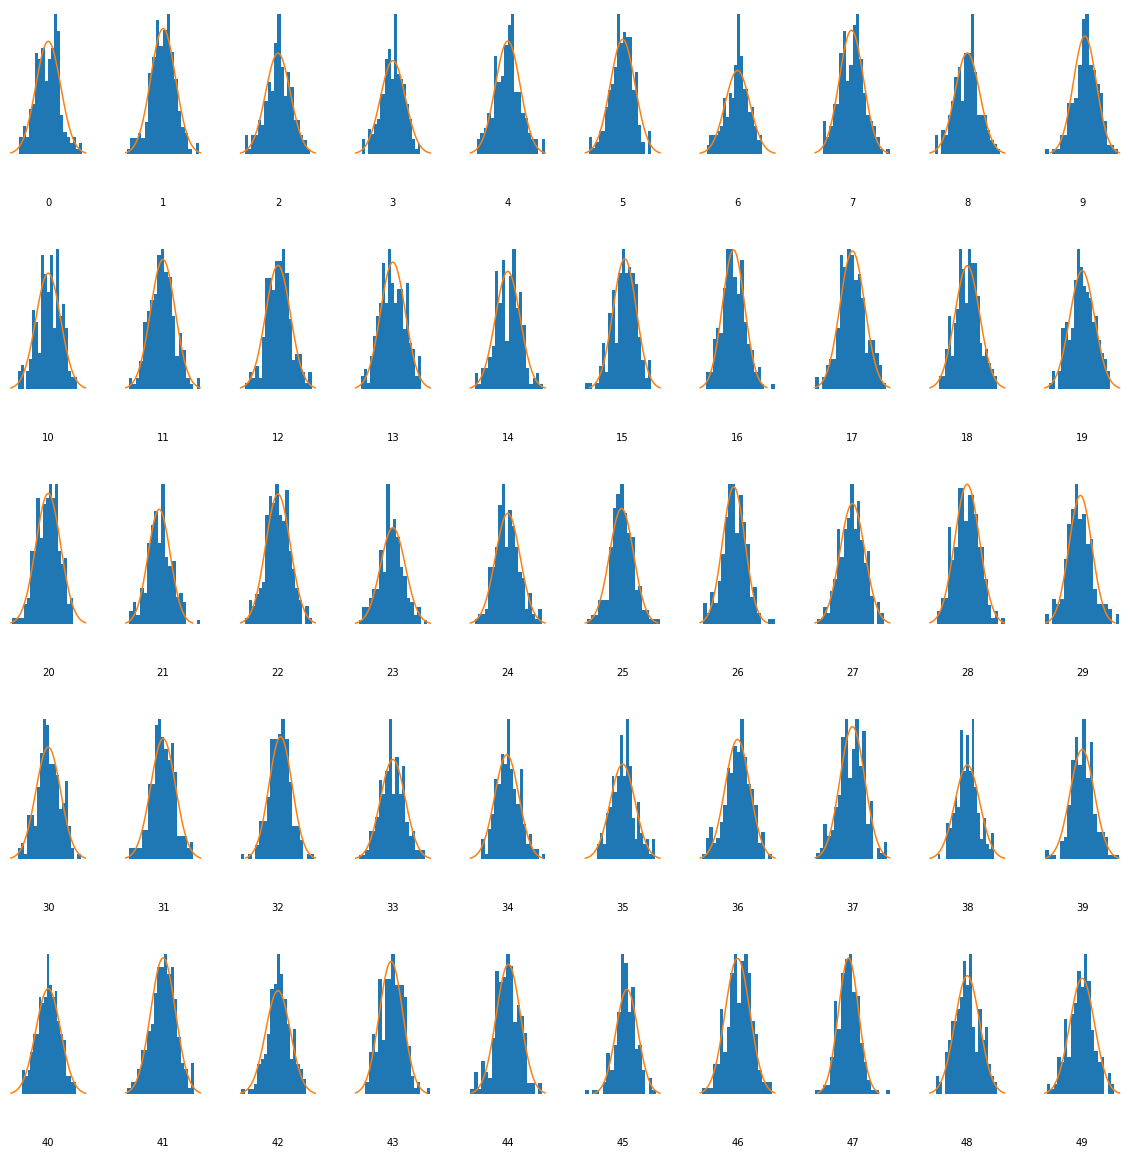

In [ ]:
z_test = vae.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

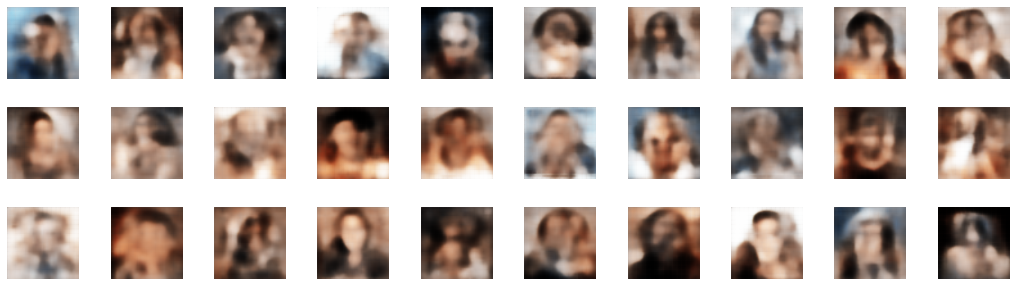

In [ ]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,vae.z_dim))

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()